<a href="https://colab.research.google.com/github/sarthakgupta99/Trader-Behavior-Insights/blob/main/notebook1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

1. DATA LOADING AND PREPROCESSING

In [2]:
fear_greed_df = pd.read_csv('fear_greed_index.csv')
historical_data_df = pd.read_csv('historical_data.csv')

/tmp/ipython-input-1083820819.py:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  historical_data_df = pd.read_csv('historical_data.csv')


In [3]:
# Convert 'date' in fear_greed_df to datetime
fear_greed_df['date'] = pd.to_datetime(fear_greed_df['date'])

In [4]:
# Convert 'Timestamp IST' in historical_data_df to datetime
# Handling the format 'DD-MM-YYYY HH:MM'
historical_data_df['datetime'] = pd.to_datetime(historical_data_df['Timestamp IST'], dayfirst=True)

In [5]:
# Extract just the date part for merging (floor to day)
historical_data_df['date'] = historical_data_df['datetime'].dt.floor('D')

In [6]:
# Merge the datasets on the 'date' column
merged_df = pd.merge(historical_data_df, fear_greed_df, on='date', how='inner')

2. ANALYSIS

In [7]:
# Group by Sentiment Classification to calculate key metrics
performance_by_sentiment = merged_df.groupby('classification').agg(
    average_pnl=('Closed PnL', 'mean'),
    total_pnl=('Closed PnL', 'sum'),
    trade_count=('Closed PnL', 'count'),
    win_rate=('Closed PnL', lambda x: (x > 0).mean()),
    average_volume=('Size USD', 'mean')
).reset_index()

In [8]:
# Filter for Realized Trades (Close Long/Short) to analyze strategy specific performance
realized_trades = merged_df[merged_df['Direction'].isin(['Close Long', 'Close Short'])]
strategy_performance = realized_trades.groupby(['classification', 'Direction'])['Closed PnL'].mean().reset_index()

print("Performance Summary by Sentiment:")
print(performance_by_sentiment)

Performance Summary by Sentiment:
  classification  average_pnl     total_pnl  trade_count  win_rate  \
0   Extreme Fear    74.511907  5.711338e+05         7665  0.367515   
1  Extreme Greed   121.280163  1.742432e+06        14367  0.509779   
2           Fear    76.444900  2.510145e+06        32836  0.450664   
3          Greed    71.536763  1.581892e+06        22113  0.398453   
4        Neutral    55.177906  1.153053e+06        20897  0.431928   

   average_volume  
0     5128.049871  
1     5916.956226  
2    10161.784070  
3    10346.419809  
4     6390.049077  


3. VISUALIZATION

/tmp/ipython-input-1879483173.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='average_pnl', data=performance_by_sentiment,
/tmp/ipython-input-1879483173.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='win_rate', data=performance_by_sentiment,


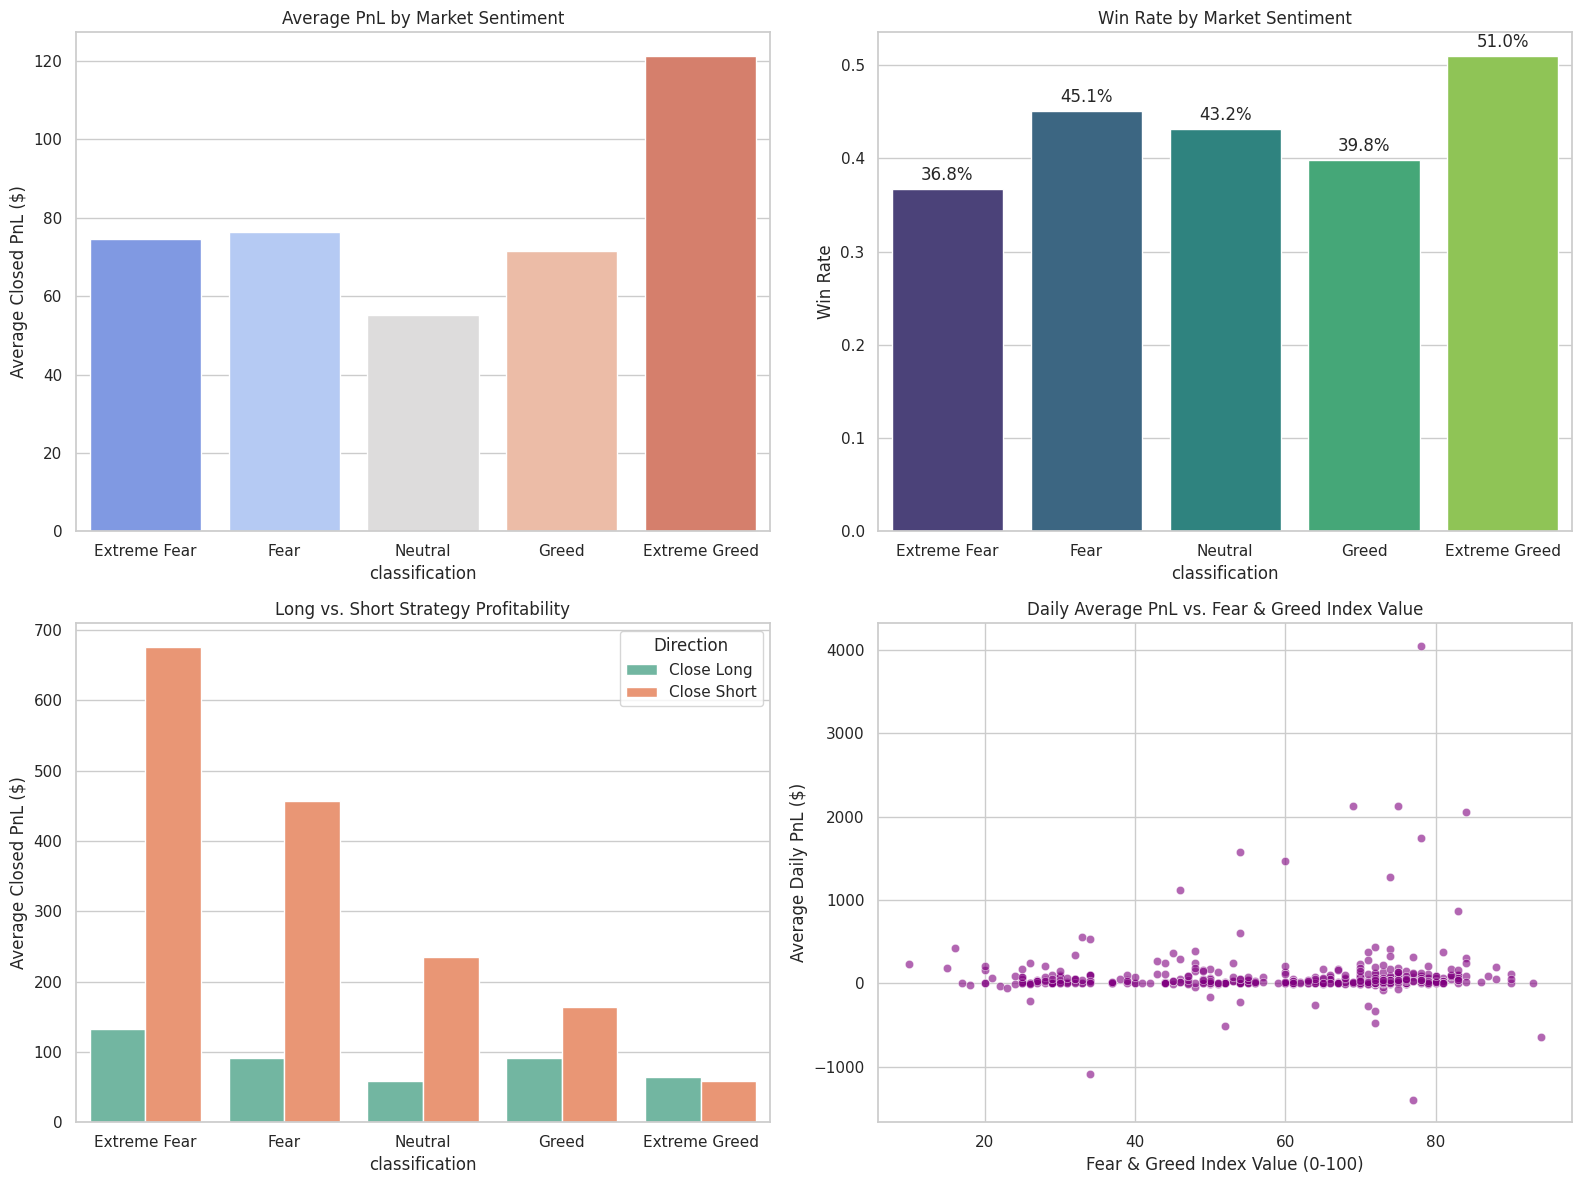

In [9]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Order for sentiment plots
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']

# Plot 1: Average PnL by Sentiment
sns.barplot(x='classification', y='average_pnl', data=performance_by_sentiment,
            order=sentiment_order, ax=axes[0, 0], palette='coolwarm')
axes[0, 0].set_title('Average PnL by Market Sentiment')
axes[0, 0].set_ylabel('Average Closed PnL ($)')

# Plot 2: Win Rate by Sentiment
sns.barplot(x='classification', y='win_rate', data=performance_by_sentiment,
            order=sentiment_order, ax=axes[0, 1], palette='viridis')
axes[0, 1].set_title('Win Rate by Market Sentiment')
axes[0, 1].set_ylabel('Win Rate')
# Add percentage labels
for p in axes[0, 1].patches:
    axes[0, 1].annotate(f'{p.get_height():.1%}',
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Plot 3: Long vs Short Profitability
sns.barplot(x='classification', y='Closed PnL', hue='Direction', data=strategy_performance,
            order=sentiment_order, ax=axes[1, 0], palette='Set2')
axes[1, 0].set_title('Long vs. Short Strategy Profitability')
axes[1, 0].set_ylabel('Average Closed PnL ($)')

# Plot 4: Daily PnL vs Fear & Greed Value (Scatter)
daily_stats = merged_df.groupby('date').agg({'Closed PnL': 'mean', 'value': 'mean'}).reset_index()
sns.scatterplot(x='value', y='Closed PnL', data=daily_stats, ax=axes[1, 1], alpha=0.6, color='purple')
axes[1, 1].set_title('Daily Average PnL vs. Fear & Greed Index Value')
axes[1, 1].set_xlabel('Fear & Greed Index Value (0-100)')
axes[1, 1].set_ylabel('Average Daily PnL ($)')

plt.tight_layout()
plt.show()